In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import glob
import cv2
import PIL
import torchvision


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# transforms and augumentations
from torchvision import transforms


_mean = [0.50]
_std = [0.50]


train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),                                  
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),                                 
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])

In [ ]:
# upload data
from torchvision import datasets, models

train_ratio = 0.8

train_path = '/content/drive/MyDrive/ANN/archive/Malaria Cells/training_set'
test_path = '/content/drive/MyDrive/ANN/archive/Malaria Cells/testing_set'

# load in data using pytorch torchvision
train_data = torchvision.datasets.ImageFolder(train_path, transform=train_transform)
test_data = torchvision.datasets.ImageFolder(test_path, transform=test_transform)

# split our train data into train and validation since validation data is not given
train_size = int(train_ratio * len(train_data))
val_size = len(train_data) - train_size
data_train, data_val = torch.utils.data.random_split(train_data, [train_size, val_size])



BATCH_SIZE = 64
n_classes = 2

In [ ]:
# dataloader
from torch.utils.data import DataLoader

train_img_loader = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
)
valid_Img_loader = DataLoader(
    data_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)
test_img_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# iterate over batche of data
dataiter = iter(train_img_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([64, 1, 32, 32])
torch.Size([64])


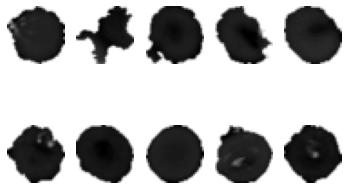

In [ ]:
#def imshow(img):
 #   img = img / 2 + 0.5  # unnormalize
  #  plt.imshow(np.transpose(img, (1, 2, 0)))

#classes = ['Parasitized', 'Uninfected']
#dataiter = iter(train_img_loader)
#images, labels = dataiter.next()
#images = images.numpy()

figure = plt.figure()
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(2, 5, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # number of hidden nodes in each layer
        hidden_layer_1 = 512
        hidden_layer_2 = 512
        hidden_layer_3 = 128
        # linear layer (3600 -> hidden_1)
        self.fc1 = nn.Linear(32 * 32, hidden_layer_1)
        # linear layer
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        # linear layer
        self.fc3 = nn.Linear(hidden_layer_2, hidden_layer_3)
        # linear layer
        self.fc4 = nn.Linear(hidden_layer_3, 2)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view (-1, 32*32)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc4(x)
        return x

# initialize the NN
model = Classifier()
model.to(device)
print(model)

Classifier(
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
from torchsummary import summary
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         524,800
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
           Dropout-4                  [-1, 512]               0
            Linear-5                  [-1, 128]          65,664
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 853,378
Trainable params: 853,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 0.02
Params size (MB): 3.26
Estimated Total Size (MB): 3.85
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_img_loader:
        #data = data.view(data.shape[0], -1)
        # move tensors to GPU
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    for data, target in valid_Img_loader:
        # move tensors to GPU
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_img_loader.dataset)
    valid_loss = valid_loss/len(valid_Img_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mlp.pt')
        valid_loss_min = valid_loss
  

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 0.685626 	Validation Loss: 0.674302
Validation loss decreased (inf --> 0.674302).  Saving model ...
Epoch: 2 	Training Loss: 0.660271 	Validation Loss: 0.643183
Validation loss decreased (0.674302 --> 0.643183).  Saving model ...
Epoch: 3 	Training Loss: 0.639147 	Validation Loss: 0.630449
Validation loss decreased (0.643183 --> 0.630449).  Saving model ...
Epoch: 4 	Training Loss: 0.628087 	Validation Loss: 0.622345
Validation loss decreased (0.630449 --> 0.622345).  Saving model ...
Epoch: 5 	Training Loss: 0.618168 	Validation Loss: 0.611187
Validation loss decreased (0.622345 --> 0.611187).  Saving model ...
Epoch: 6 	Training Loss: 0.610819 	Validation Loss: 0.608553
Validation loss decreased (0.611187 --> 0.608553).  Saving model ...
Epoch: 7 	Training Loss: 0.604030 	Validation Loss: 0.605976
Validation loss decreased (0.608553 --> 0.605976).  Saving model ...
Epoch: 8 	Training Loss: 0.600403 	Validation Loss: 0.603258
Validation loss decreased (0.60597

In [ ]:
test_loss = 0
correct = 0
total_label = 0
count = 0
sum_acc = 0
actual = []
pred = []
model.to(device)
with torch.no_grad():
  model.eval()
  for data, target in test_img_loader:
      # move tensors to GPU if CUDA is available
      
      data, target = data.to(device), target.to(device)
      actual.append(target.data.tolist())
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update average validation loss 
      test_loss += loss.item()*data.size(0)
      count += 1
      
      #Accuracy
      _, predicted = torch.max(output.data, 1)
      pred.append(predicted.data.tolist())
      #print(classification_report(target, predicted, labels=classes, digits=4))
      total_label += target.size(0)
      correct += (predicted == target).sum().item()
      acc = (correct/total_label)
      sum_acc += acc
      print (f'accuracy: {acc * 100}%')
print (f'Average Accuracy: {sum_acc/count * 100}%')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


accuracy: 64.0625%
accuracy: 81.25%
accuracy: 86.45833333333334%
accuracy: 86.71875%
accuracy: 88.4375%
accuracy: 88.54166666666666%
accuracy: 85.49107142857143%
accuracy: 83.3984375%
accuracy: 80.90277777777779%
accuracy: 78.59375%
accuracy: 79.6875%
accuracy: 80.078125%
accuracy: 80.88942307692307%
accuracy: 81.91964285714286%
accuracy: 82.39583333333333%
accuracy: 83.49609375%
accuracy: 84.00735294117648%
accuracy: 84.11458333333334%
accuracy: 83.22368421052632%
accuracy: 83.28125%
accuracy: 83.55654761904762%
accuracy: 84.01988636363636%
accuracy: 84.30706521739131%
accuracy: 84.5703125%
accuracy: 84.3125%
accuracy: 84.07451923076923%
accuracy: 83.79629629629629%
accuracy: 83.76116071428571%
accuracy: 83.35129310344827%
accuracy: 83.4375%
accuracy: 83.41733870967742%
accuracy: 83.69140625%
accuracy: 82.57575757575758%
accuracy: 81.61764705882352%
accuracy: 80.49107142857143%
accuracy: 79.47048611111111%
accuracy: 78.58952702702703%
accuracy: 78.125%
accuracy: 77.40384615384616%
acc

In [ ]:
def load_input_image(img_path):    
    image = Image.open(img_path)
    pred_transform = transforms.Compose([transforms.Resize(size=(32, 32)),
                                     transforms.Grayscale(num_output_channels= 1),    
                                     transforms.ToTensor(), 
                                     transforms.Normalize(_mean, _std),])
                                                    

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = pred_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [ ]:
def predict_malaria(model, n_class, img_path):
    # load the image and return the predicted class
    img = load_input_image(img_path)
    img = img.to(device)
    model = model.to(device)
    model.eval()
    idx = torch.argmax(model(img))
    return n_class[idx]

Parasitized


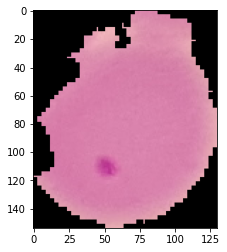

Parasitized


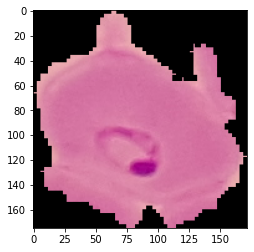

Uninfected


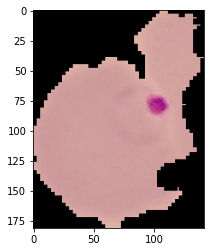

Parasitized


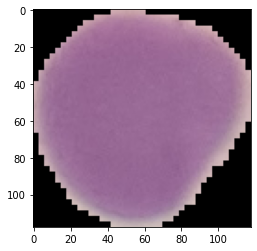

Parasitized


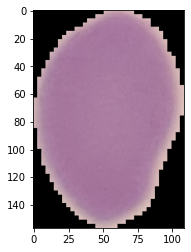

Parasitized


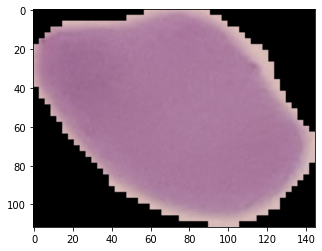

In [ ]:
from glob import glob
from PIL import Image
from termcolor import colored

n_classes=['Parasitized','Uninfected']
infected = np.array(glob("/content/drive/MyDrive/ANN/archive/Malaria Cells/testing_set/Parasitized/*"))
Uninfected = np.array(glob("/content/drive/MyDrive/ANN/archive/Malaria Cells/testing_set/Uninfected/*"))
for i in range(3):
    img_path=infected[i]
    img = Image.open(img_path)
    if predict_malaria(model, n_classes, img_path) == 'Parasitized':
        print(colored('Parasitized', 'green'))
    else:
        print(colored('Uninfected', 'red'))
    plt.imshow(img)
    plt.show()
for i in range(3):
    img_path=Uninfected[i]
    img = Image.open(img_path)
    if predict_malaria(model, n_classes, img_path) == 'Uninfected':
        print(colored('Uninfected', 'green'))
    else:
        print(colored('Parasitized', 'red'))        
    plt.imshow(img)
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools
predict = list(itertools.chain.from_iterable(pred))
results = confusion_matrix(actual, predict)
print("Report")
print(classification_report(actual, predict))
print("confustion matrix: ")
print(pd.DataFrame(results,columns=["Predicted No","Predicted Yes"],index=["Actual No", "Actual Yes"]))

ValueError: ignored